# Rob's Capstone Project

This notebook with contain my work for the [capstone project](https://www.coursera.org/learn/applied-data-science-capstone/home/welcome) for IBM Data Science Specialization certificate.
### Week 5

**Name**: Robert Barrimond

**Date**: May 20, 2021

**REVIEWER PLEASE NOTE**
I do _not_ comment my code with Markdown. As an SRE (Site Reliability Engineer), I do as application developers should do: document code _in the code_ and everywhere possible by the code itself. Having said that, SREs are also called to be data scientists as well. So, I use Markdown to "tell the story" as that first overview course taught me so many months ago. I hope this assignment was easy to follow and grade!

---

## Problem Statement
I've decided to see if it's worth pursuing opening a Cambodian restaurant somewhere in Toronto. I noticed from the previous assignments that the city is quite cosmopolitan and would welcome such a restaurant. The real problem is _where_ to locate it. My strategy will be to narrow the list of venues to Asian restaurants, get premium data on just those venues, e.g. number of like and rating, and use that to produce better clusters that can make my decision easier.


In [34]:
#
# Import the necessary modules
#

# Data analysis and transformation
import pandas as pd
import numpy as np

# REST API access
import requests

# File access
import os
from os import path
import pickle

# Geocoders
import geopy
from geopy.geocoders import Nominatim

# Regex
import re

# Progress bars
from tqdm import tqdm

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Mapping
import folium

# DBSCAN for spacial clustering
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler


## Retrieve and Clean Venue Data

Because it took [some work](https://github.com/rbarrimond/Coursera_Capstone/blob/5afe9c180839529c96ee71c8a5fae69746b9f4c3/toronto-kmeans-clustering.ipynb) to build a clean dataframe of FSAs from Wikipedia, I'll omit that work here and simple read the pickle from disk. Next I use the Foursquare API `explore` endpoint to get all the nearby venues. Once I retrieve these I'll sift out all restaurants and make Asain restaurants as a feature to use in my clustering analysis. This is a improvement over what was done in Week 4. I learned a good bit on getting information from the explore API up front and using that correct FSAs. This time I'm going to clean *all* the FSAs for *all* venues not just restaurants. Then I'll enrich just the asian restaurants for more detailed analysis.

In [35]:
# Load the FSA data from previous work
fsa_df = pd.read_pickle('fsa_df.pkl')
fsa_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [36]:
# FourSquare credentials
CLIENT_ID = '0II4MXQK5GVKQA3YIZRXT3D0KWBAKEH2BCCYRWIK4H0DS5XH' # your Foursquare ID
CLIENT_SECRET = 'ZBOCOGUCP2AXOQNAFSPX05IAXWAPBNUBC2FTAGYJV4DDS3AA' # your Foursquare Secret
ACCESS_TOKEN = 'ESEQDUIWNVRAS11OKDDXMICGNUPXLZCHPVHCZ53OTT2LQWBS' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [37]:
# This function takes a sequence of names, lats and longs and produces a dataframe of nearby venues
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    nearby_venues = pd.DataFrame()

    with tqdm(total=len(names)) as pbar:
        for name, lat, lng in zip(names, latitudes, longitudes):
                
            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search'
            payload = {
                'client_id': CLIENT_ID,
                'client_secret': CLIENT_SECRET,
                'v': VERSION,
                'll': '{},{}'.format(lat,lng),
                'radius': radius,
                'limit': LIMIT
            }
        
            # make the GET request, raise exception if an error
            r = requests.get(url, params=payload)
            r.raise_for_status()
            
            # create dataframe, return only relevant information for each nearby venue
            results = pd.json_normalize(r.json()["response"]['venues'])
            results.rename(columns={
                                    'id': 'Venue ID',
                                    'name': 'Venue', 
                                    'location.lat': 'Venue Latitude', 
                                    'location.lng': 'Venue Longitude',
                                    'location.address': 'Venue Address',
                                    'location.postalCode': 'Venue Postal Code'
                                }, inplace=True)
            results['Venue Category'] = results['categories'].loc[ results['categories'].notna() ].apply(lambda x: x[0]['name'] if len(x) > 0 else None)
            results['Neighborhood'] = name
            results['Neighborhood Latitude'] = lat
            results['Neighborhood Longitude'] = lng

            columns = ['Neighborhood', 
                        'Neighborhood Latitude', 
                        'Neighborhood Longitude', 
                        'Venue ID',
                        'Venue', 
                        'Venue Latitude', 
                        'Venue Longitude',
                        'Venue Address',
                        'Venue Postal Code',
                        'Venue Category']

            nearby_venues = nearby_venues.append(results[columns], ignore_index=True)
            pbar.update()
            
    return nearby_venues

In [38]:
# Retrieve all the venues in Toronto
toronto_venues = getNearbyVenues(fsa_df['PostalCode'], fsa_df['Latitude'], fsa_df['Longitude'])

# Quick cleanup
toronto_venues.drop_duplicates(subset=['Venue ID'], inplace=True, ignore_index=True)
toronto_venues.dropna(axis='index', subset=['Venue Category'], inplace=True)
toronto_venues.reset_index(drop=True, inplace=True)
toronto_venues['Venue Postal Code'] = toronto_venues['Venue Postal Code'].str.upper()
toronto_venues

100%|██████████| 103/103 [00:19<00:00,  5.33it/s]


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Address,Venue Postal Code,Venue Category
0,M3A,43.753259,-79.329656,4e8d9dcdd5fbbbb6b3003c7b,Brookbanks Park,43.751976,-79.332140,Toronto,NaN,Park
1,M3A,43.753259,-79.329656,4f3a69f9e4b024185be5a99b,17 Brookbanks Drive,43.752266,-79.332322,15 Brookbanks Dr.,M3A 2S9,Residential Building (Apartment / Condo)
2,M3A,43.753259,-79.329656,4dcc586845dd853165f01864,Tailor Made,43.741513,-79.319707,NaN,NaN,Laundry Service
3,M3A,43.753259,-79.329656,5e111e7e9316a70007fb9653,Subway,43.760334,-79.326906,"1277 York Mills Road, Unit F1-2, Bldg F",M3A 1Z5,Sandwich Place
4,M3A,43.753259,-79.329656,4bda3d363904a59320d5459e,Joey,43.753441,-79.321640,NaN,NaN,Burger Joint
...,...,...,...,...,...,...,...,...,...,...
8692,M8Z,43.628841,-79.520999,4b4a2c3ff964a520507d26e3,Jim & Maria's No Frills,43.631152,-79.518617,1020 Islington Ave,M8Z 6A4,Grocery Store
8693,M8Z,43.628841,-79.520999,4c34d41a16adc928b6d3c59c,Food Depot International,43.627208,-79.527310,14 Jutland Road,M8Z 2G9,Food & Drink Shop
8694,M8Z,43.628841,-79.520999,4ee23ae71e1778df278ca4c2,StorageMart,43.634341,-79.520239,144 Norseman St,M8Z 2R4,Storage Facility
8695,M8Z,43.628841,-79.520999,5bd2598b8fb09e002c343e3c,Access Abilities,43.633658,-79.521332,154 Norseman St,M8Z 2R4,Medical Supply Store


As we can see there are some mismatches in the data. The FSAs that we initially set as `Neighborhood` don't match the offical FSA in `Venue Postal Code`. The good news is that most of them were pretty close so that bodes well for me to start adjusting the `Neighborhood` column to reflect the "true" FSA. The first thing to do is clean the column and adjust the known FSAs.

In [39]:
# Clean up invalid values for the FSA
toronto_venues.loc[ ~toronto_venues['Venue Postal Code'].str.fullmatch('(\w{3}(?:\s{1}\w{3})?).*$', na=False), 'Venue Postal Code' ] = np.nan

# Create masks to filter the dataframe
postal_code_mask = pd.notna(toronto_venues['Venue Postal Code'])
postal_code_match_mask = (toronto_venues['Venue Postal Code'].str.extract('^(\w{3})', expand=False) == toronto_venues['Neighborhood'])
address_mask = pd.notna(toronto_venues['Venue Address'])

# Venues with mismatched postal codes
toronto_venues[['Venue','Neighborhood','Venue Postal Code', 'Venue Address']].loc[~postal_code_match_mask]

,Venue,Neighborhood,Venue Postal Code,Venue Address
0,Brookbanks Park,M3A,NaN,Toronto
2,Tailor Made,M3A,NaN,NaN
4,Joey,M3A,NaN,NaN
5,Pheasant Run Golf Course,M3A,NaN,NaN
6,Shoppers Drug Mart,M3A,M3B 2M1,1859 Leslie St
...,...,...,...,...
8677,Nourish Family Chiropractic,M8Z,NaN,NaN
8680,Yogen Früz,M8Z,NaN,1025 The Queensway
8682,Once Upon A Child,M8Z,NaN,NaN
8685,Titan Plaza,M8Z,NaN,1020 Islington Ave


In [40]:
# Adjust Neighborhood to known FSA
mask = postal_code_mask & ~postal_code_match_mask
toronto_venues.loc[ mask, 'Neighborhood'] = toronto_venues.loc[mask, 'Venue Postal Code'].str.extract('^(\w{3})', expand=False)

# Reset masks
postal_code_mask = pd.notna(toronto_venues['Venue Postal Code'])
postal_code_match_mask = (toronto_venues['Venue Postal Code'].str.extract('^(\w{3})', expand=False) == toronto_venues['Neighborhood'])
address_mask = pd.notna(toronto_venues['Venue Address'])

# Check results
toronto_venues[['Venue','Neighborhood','Venue Postal Code', 'Venue Address']].loc[~postal_code_match_mask]

,Venue,Neighborhood,Venue Postal Code,Venue Address
0,Brookbanks Park,M3A,NaN,Toronto
2,Tailor Made,M3A,NaN,NaN
4,Joey,M3A,NaN,NaN
5,Pheasant Run Golf Course,M3A,NaN,NaN
10,Mrs. Claus' Sweatshop,M3A,NaN,Cassandra Blvd.
...,...,...,...,...
8676,Kipling Carwash,M8Z,NaN,NaN
8677,Nourish Family Chiropractic,M8Z,NaN,NaN
8680,Yogen Früz,M8Z,NaN,1025 The Queensway
8682,Once Upon A Child,M8Z,NaN,NaN


Next we use Nominatum to do reverse lookups of each venue to update its postal code where that postal code is not set.

In [41]:
# Find remaining venues that need to be adjusted
postal_code_mask = pd.notna(toronto_venues['Venue Postal Code'])
postal_code_match_mask = (toronto_venues['Venue Postal Code'].str.extract('^(\w{3})', expand=False) == toronto_venues['Neighborhood'])
address_mask = pd.notna(toronto_venues['Venue Address'])
mask = ~postal_code_match_mask & ~postal_code_mask

# Do a reverse geocode lookup and extract postal code from address found
p = re.compile(r"Ontario, (\w{3}(?:\s{1}\w{3})?).*$")
geolocator = Nominatim(user_agent="robs_ba_explorer")
for index in tqdm(toronto_venues[mask].index):
    location = geolocator.reverse("{}, {}".format(toronto_venues.loc[index, 'Venue Latitude'], toronto_venues.loc[index, 'Venue Longitude']))
    m = p.search(location.address)
    toronto_venues.loc[index, 'Venue Postal Code'] = m.group(1)
    toronto_venues.loc[index, 'Neighborhood'] = m.group(1)[0:3]
toronto_venues[mask]

100%|██████████| 5186/5186 [43:13<00:00,  2.00it/s]


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Address,Venue Postal Code,Venue Category
0,M3A,43.753259,-79.329656,4e8d9dcdd5fbbbb6b3003c7b,Brookbanks Park,43.751976,-79.332140,Toronto,M3A 1S5,Park
2,M3A,43.753259,-79.329656,4dcc586845dd853165f01864,Tailor Made,43.741513,-79.319707,NaN,M3A 1C6,Laundry Service
4,M3A,43.753259,-79.329656,4bda3d363904a59320d5459e,Joey,43.753441,-79.321640,NaN,M3A 2M8,Burger Joint
5,M3A,43.753259,-79.329656,4c4c83c646240f47898fe7f4,Pheasant Run Golf Course,43.758386,-79.337191,NaN,M3A 3L6,Golf Course
10,M3A,43.753259,-79.329656,4fbb0e50e4b01b3b56de45c9,Mrs. Claus' Sweatshop,43.753800,-79.319582,Cassandra Blvd.,M3A 2M8,Public Art
...,...,...,...,...,...,...,...,...,...,...
8676,M8Z,43.628841,-79.520999,4eab18036c250fcc74755952,Kipling Carwash,43.627631,-79.528079,NaN,M8Z 5G5,Automotive Shop
8677,M8Z,43.628841,-79.520999,58e8ffb7fb9d897d4bc5c9cc,Nourish Family Chiropractic,43.631457,-79.519147,NaN,M8Z 2R4,Chiropractor
8680,M8Z,43.628841,-79.520999,4f518d18e4b0061513a53d7a,Yogen Früz,43.626289,-79.515847,1025 The Queensway,M8Z 2G6,Ice Cream Shop
8682,M8Z,43.628841,-79.520999,53aad60b498ef2b98028e860,Once Upon A Child,43.631075,-79.518290,NaN,M8Z 2G6,Kids Store


In [42]:
# Fix the lat, long of the Neighborhoods
pd.reset_option("max_rows")
fix_lat_long = fsa_df.set_index('PostalCode')[ ['Latitude', 'Longitude'] ]
toronto_venues = toronto_venues.join(fix_lat_long, on='Neighborhood')
toronto_venues = toronto_venues.drop(columns=[ 'Neighborhood Latitude', 'Neighborhood Longitude'])
toronto_venues = toronto_venues.rename(columns={
    'Latitude': 'Neighborhood Latitude',
    'Longitude': 'Neighborhood Longitude'
})
cols = toronto_venues.columns.to_list()
cols = [cols[0]] + cols[-2:] + cols[1:-2]
toronto_venues = toronto_venues[cols]
with open('toronto_venue.pkl', 'wb') as f:
    pickle.dump(toronto_venues, f, pickle.HIGHEST_PROTOCOL)
toronto_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Address,Venue Postal Code,Venue Category
0,M3A,43.753259,-79.329656,4e8d9dcdd5fbbbb6b3003c7b,Brookbanks Park,43.751976,-79.332140,Toronto,M3A 1S5,Park
1,M3A,43.753259,-79.329656,4f3a69f9e4b024185be5a99b,17 Brookbanks Drive,43.752266,-79.332322,15 Brookbanks Dr.,M3A 2S9,Residential Building (Apartment / Condo)
2,M3A,43.753259,-79.329656,4dcc586845dd853165f01864,Tailor Made,43.741513,-79.319707,NaN,M3A 1C6,Laundry Service
3,M3A,43.753259,-79.329656,5e111e7e9316a70007fb9653,Subway,43.760334,-79.326906,"1277 York Mills Road, Unit F1-2, Bldg F",M3A 1Z5,Sandwich Place
4,M3A,43.753259,-79.329656,4bda3d363904a59320d5459e,Joey,43.753441,-79.321640,NaN,M3A 2M8,Burger Joint
...,...,...,...,...,...,...,...,...,...,...
8692,M8Z,43.628841,-79.520999,4b4a2c3ff964a520507d26e3,Jim & Maria's No Frills,43.631152,-79.518617,1020 Islington Ave,M8Z 6A4,Grocery Store
8693,M8Z,43.628841,-79.520999,4c34d41a16adc928b6d3c59c,Food Depot International,43.627208,-79.527310,14 Jutland Road,M8Z 2G9,Food & Drink Shop
8694,M8Z,43.628841,-79.520999,4ee23ae71e1778df278ca4c2,StorageMart,43.634341,-79.520239,144 Norseman St,M8Z 2R4,Storage Facility
8695,M8Z,43.628841,-79.520999,5bd2598b8fb09e002c343e3c,Access Abilities,43.633658,-79.521332,154 Norseman St,M8Z 2R4,Medical Supply Store


## Tag Asian Restaurants as a Feature Using the Foursquare API

In [43]:
# Explore the types of restaurants
restaurants = toronto_venues.loc[ toronto_venues['Venue Category'].str.contains('restaurant', case=False, regex=True) ].copy()
restaurants.reset_index(drop=True, inplace=True)
types = restaurants['Venue Category'].str.replace("Restaurant", "").str.strip().unique()
sorted(types)

['',
 'Afghan',
 'African',
 'American',
 'Argentinian',
 'Asian',
 'Bangladeshi',
 'Belgian',
 'Brazilian',
 'Cajun / Creole',
 'Cantonese',
 'Caribbean',
 'Chinese',
 'Comfort Food',
 'Cuban',
 'Dim Sum',
 'Dumpling',
 'Eastern European',
 'English',
 'Ethiopian',
 'Falafel',
 'Fast Food',
 'Filipino',
 'French',
 'German',
 'Gluten-free',
 'Greek',
 'Hakka',
 'Halal',
 'Hungarian',
 'Indian',
 'Italian',
 'Japanese',
 'Jewish',
 'Korean',
 'Korean BBQ',
 'Latin American',
 'Mediterranean',
 'Mexican',
 'Middle Eastern',
 'Modern European',
 'Moroccan',
 'New American',
 'North Indian',
 'Pakistani',
 'Peking Duck',
 'Persian',
 'Portuguese',
 'Ramen',
 'Seafood',
 'South Indian',
 'Sri Lankan',
 'Sushi',
 'Swiss',
 'Szechuan',
 'Tapas',
 'Thai',
 'Theme',
 'Tibetan',
 'Turkish',
 'Vegetarian / Vegan',
 'Vietnamese']

In [44]:
# Set the Asian categories based on the above and create a cleaned restaurants dataframe that calls out asian restaurants
asian_categories = [ 'Asian', 'Cambodian', 'Cantonese', 'Chinese', 'Dim Sum', 'Dumpling', 'Filipino', 'Hakka', 'Japanese', 'Korean', 'Korean BBQ', 'Peking Duck', 'Ramen', 'Shanghai', 'Sushi', 'Szechuan', 'Thai', 'Tibetan', 'Vietnamese']
restaurants['Asian'] = restaurants['Venue Category'].str.contains("|".join(asian_categories), case=False, regex=True)

In [45]:
# How many Asian restaurants
restaurants.groupby(by=['Asian']).count()['Venue ID']

Asian
False    482
True     243
Name: Venue ID, dtype: int64

### Pull Full Data from Foursquare for Each Asian Restaurant
NOTE: The `/venue` endpoint is a premium API. As a result, I cached results to file. 


In [46]:
# Read in venue data either from cache or from Foursquare
asian_venue_data = {}
if path.exists('asian_venue_data.pkl'):
    with open('asian_venue_data.pkl', 'rb') as f:
        asian_venue_data = pickle.load(f)
else:
    payload = {
        'client_id': CLIENT_ID,
        'client_secret': CLIENT_SECRET,
        'v': VERSION
        }

    for venue_id in tqdm(restaurants.loc[ restaurants['Asian'] == True, 'Venue ID']):
        try:
            url = 'https://api.foursquare.com/v2/venues/{}'.format(venue_id)
            r = requests.get(url, params=payload)
            r.raise_for_status()
            asian_venue_data[venue_id] = r.json()['response']
        except:
            pass        
       
    with open('asian_venue_data.pkl', 'wb') as f:
        pickle.dump(asian_venue_data, f, pickle.HIGHEST_PROTOCOL)


In [47]:
# Create a dataframe for the venue data
asian_venue_data_df = pd.DataFrame()
for id in tqdm(asian_venue_data):
    asian_venue_data_df = asian_venue_data_df.append(pd.json_normalize(asian_venue_data[id]), ignore_index=True)
asian_venue_data_df.set_index('venue.id', inplace=True)
asian_venue_data_df

100%|██████████| 264/264 [00:04<00:00, 54.46it/s]


,venue.name,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,venue.location.cc,venue.location.country,venue.location.formattedAddress,venue.canonicalUrl,venue.categories,venue.verified,...,venue.page.user.type,venue.page.user.tips.count,venue.page.user.lists.groups,venue.page.user.bio,venue.location.neighborhood,venue.venuePage.id,venue.storeId,venue.page.user.venue.id,venue.parent.location.neighborhood,venue.page.pageInfo.description
venue.id,,,,,,,,,,,,,,,,,,,,,
4f73a473e4b0c1f445d21c78,Huayu Kitchen,43.654148,-79.357826,"[{'label': 'display', 'lat': 43.65414810180664...",CA,Canada,[Canada],https://foursquare.com/v/huayu-kitchen/4f73a47...,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5ab3d9f875a6ea3a7ddc4d2b,Thai Express,43.661630,-79.387340,"[{'label': 'display', 'lat': 43.66163, 'lng': ...",CA,Canada,"[76 Grenville St, Toronto ON M5S 1B2, Canada]",https://foursquare.com/v/thai-express/5ab3d9f8...,"[{'id': '4bf58dd8d48988d149941735', 'name': 'T...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59a86be58d1070397a5101be,Sushi Shop,43.661620,-79.387636,"[{'label': 'display', 'lat': 43.66162, 'lng': ...",CA,Canada,"[76 Grenville St, Woman's College Hospital, To...",https://foursquare.com/v/sushi-shop/59a86be58d...,"[{'id': '4bf58dd8d48988d1d2941735', 'name': 'S...",True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4c61c478edd320a1835bab29,Bella's Lechon,43.801291,-79.198378,"[{'label': 'display', 'lat': 43.80129149338062...",CA,Canada,"[1139 Morningside Ave, Unit 23, Toronto ON M1B...",https://foursquare.com/v/bellas-lechon/4c61c47...,"[{'id': '4eb1bd1c3b7b55596b4a748f', 'name': 'F...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4c706524df6b8cfab244b84d,Charley's Exotic Cuisine,43.800982,-79.200233,"[{'label': 'display', 'lat': 43.80098159718747...",CA,Canada,"[3-1158 Morningside Ave (Sheppard Ave), Toront...",https://foursquare.com/v/charleys-exotic-cuisi...,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56b2cd62498e0819ad42f567,My Little Dumplings,43.664504,-79.325709,"[{'label': 'display', 'lat': 43.66450364048565...",CA,Canada,"[1372 Queen St E (at Greenwood Ave), Toronto O...",https://foursquare.com/v/my-little-dumplings/5...,"[{'id': '4bf58dd8d48988d108941735', 'name': 'D...",False,...,NaN,NaN,NaN,NaN,"Leslieville, Toronto, ON",NaN,NaN,NaN,NaN,NaN
5d34d6dfe57689000792bf15,Hakka Fire,43.693030,-79.315832,"[{'label': 'display', 'lat': 43.69303, 'lng': ...",CA,Canada,"[1235 Woodbine Avenue (Lumsden Avenue), Toront...",https://foursquare.com/v/hakka-fire/5d34d6dfe5...,"[{'id': '52af3ac83cf9994f4e043bf3', 'name': 'H...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4b1711a6f964a520cbc123e3,Federick Restaurant,43.774697,-79.241142,"[{'label': 'display', 'lat': 43.77469659057996...",CA,Canada,"[1920 Ellesmere Rd (at Bellamy Rd. N), Scarbor...",https://foursquare.com/v/federick-restaurant/4...,"[{'id': '52af3ac83cf9994f4e043bf3', 'name': 'H...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
#
# Join key data fields to the restaurants data frame and identify the dupes
#
key_venue_cols = [
    'venue.stats.tipCount',
    'venue.price.tier',
    'venue.rating',
    'venue.likes.count'
]
restaurants = restaurants.join(asian_venue_data_df[key_venue_cols], on='Venue ID')

# Cleanup columns
restaurants.rename(columns={
    'venue.stats.tipCount': 'Venue Tip Count',
    'venue.price.tier': 'Venue Price Tier',
    'venue.rating': 'Venue Rating',
    'venue.likes.count': 'Venue Likes'
}, inplace=True)

restaurants['Venue Price Tier'] = restaurants['Venue Price Tier'].astype(pd.Int64Dtype())
restaurants['Venue Tip Count'] = restaurants['Venue Tip Count'].astype(pd.Int64Dtype())
restaurants['Venue Likes'] = restaurants['Venue Likes'].astype(pd.Int64Dtype())

# Drop invalid neighborhoods
restaurants.dropna(subset=['Neighborhood Latitude', 'Neighborhood Longitude'], inplace=True)

restaurants

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Address,Venue Postal Code,Venue Category,Asian,Venue Tip Count,Venue Price Tier,Venue Rating,Venue Likes
0,M3A,43.753259,-79.329656,4b8991cbf964a520814232e3,Allwyn's Bakery,43.759840,-79.324719,81 Underhill drive,M3A 1Z5,Caribbean Restaurant,False,<NA>,<NA>,NaN,<NA>
1,M3A,43.753259,-79.329656,4e6696b6d16433b9ffff47c3,KFC,43.754387,-79.333021,NaN,M3A 2S3,Fast Food Restaurant,False,<NA>,<NA>,NaN,<NA>
2,M4A,43.725882,-79.315572,4d689350b6f46dcb77ee15b2,The Frig,43.727051,-79.317418,NaN,M4A 1K2,French Restaurant,False,<NA>,<NA>,NaN,<NA>
3,M4A,43.725882,-79.315572,4f3ecce6e4b0587016b6f30d,Portugril,43.725819,-79.312785,1733 Eglinton Avenue East,M4A 1J8,Portuguese Restaurant,False,<NA>,<NA>,NaN,<NA>
4,M4A,43.725882,-79.315572,51c1d125498ef8fda0942e6c,Vinnia Meats,43.730465,-79.307520,1050 Birchmount Ave,M4A 2B1,German Restaurant,False,<NA>,<NA>,NaN,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720,M4L,43.668999,-79.315572,4ad9ebdcf964a520e61b21e3,Chick-n-Joy,43.665181,-79.321403,1483 Queen St. E,M4L 1E2,Fast Food Restaurant,False,<NA>,<NA>,NaN,<NA>
721,M8Z,43.628841,-79.520999,4aec9552f964a52007c921e3,McDonald's,43.630007,-79.518041,1001 Islington Ave,M8Z 4P8,Fast Food Restaurant,False,<NA>,<NA>,NaN,<NA>
722,M8Z,43.628841,-79.520999,4c6d5881e13db60c516ed8b1,Lakeshore Super Submarine,43.627321,-79.529354,2939 Lakeshore Blvd West,M8Z 5G5,Fast Food Restaurant,False,<NA>,<NA>,NaN,<NA>
723,M8Z,43.628841,-79.520999,4beb20e1a9900f4729691740,Babaz,43.634295,-79.519504,NaN,M8Z 2R4,Fast Food Restaurant,False,<NA>,<NA>,NaN,<NA>


In [49]:
# Save the data to file
with open('restaurants.pkl', 'wb') as f:
        pickle.dump(restaurants, f, pickle.HIGHEST_PROTOCOL)

## Analyze Restaurants
### Categorizing Each Postal Code by All Restaurants with Emphasis on Asian
By taking the mean across each postal code you get a measure of what percentage of that postal code is characterized by the venue category. The advantage of this is that the data is already scaled from zero to one. This is the final result we want: each postal code with segmented by its makeup of venue categories.

In [5]:
if path.exists('restaurants.pkl'):
    with open('restaurants.pkl', 'rb') as f:
        restaurants = pickle.load(f)

restaurant_one_hot = pd.get_dummies(restaurants['Venue Category'], prefix='', prefix_sep='')

# add neighborhood columns back to dataframe
restaurant_one_hot['Neighborhood'] = restaurants['Neighborhood'] 
restaurant_one_hot['Asian'] = restaurants['Asian'].astype(int)

# move neighborhood column to the first column
fixed_columns = list(restaurant_one_hot.columns[-2:]) + list(restaurant_one_hot.columns[:-2])
restaurant_one_hot = restaurant_one_hot[fixed_columns]

restaurant_neighborhoods = restaurant_one_hot.groupby('Neighborhood').mean()
restaurant_neighborhoods.head(10)

,Asian,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Bangladeshi Restaurant,Belgian Restaurant,Brazilian Restaurant,Burmese Restaurant,...,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,
M1B,0.187500,0.0,0.062500,0.000000,0.0,0.062500,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
M1C,0.285714,0.0,0.142857,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
M1E,0.200000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
M1G,0.222222,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
M1H,0.277778,0.0,0.000000,0.000000,0.0,0.055556,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0.055556,0.0
M1J,0.250000,0.0,0.000000,0.000000,0.0,0.125000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
M1K,0.444444,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.111111,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
M1L,0.250000,0.0,0.000000,0.000000,0.0,0.083333,0.083333,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
M1M,0.333333,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.000000,0.0


array([[<AxesSubplot:title={'center':'k = 3'}>,
        <AxesSubplot:title={'center':'k = 4'}>,
        <AxesSubplot:title={'center':'k = 5'}>],
       [<AxesSubplot:title={'center':'k = 6'}>,
        <AxesSubplot:title={'center':'k = 7'}>,
        <AxesSubplot:title={'center':'k = 8'}>],
       [<AxesSubplot:title={'center':'k = 9'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

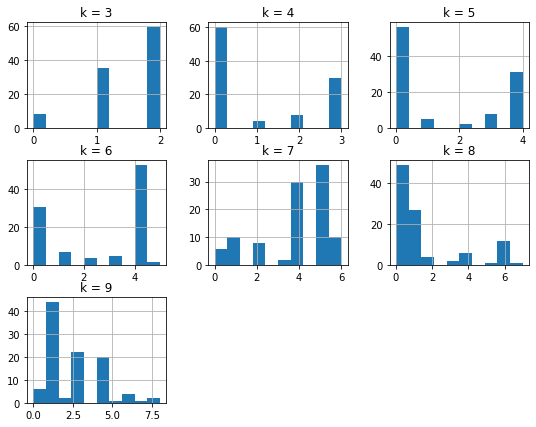

In [6]:
# Analyze k means values
k_bins = pd.DataFrame()
for k in range(3, 10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(restaurant_neighborhoods)
    col_title = 'k = ' + str(k)
    k_bins[col_title] = pd.Series(kmeans.labels_)

k_bins.hist(figsize=(9,7))

In [7]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(restaurant_neighborhoods)

# check cluster labels generated for each row in the dataframe
print('Cluster Labels:\n', kmeans.labels_)
restaurant_neighborhoods.insert(0, 'Cluster', kmeans.labels_)
restaurant_neighborhoods.head(10)

Cluster Labels:
 [4 4 4 4 4 4 0 4 4 4 4 4 0 4 0 4 4 0 0 0 3 0 0 4 1 1 0 0 0 0 0 0 4 4 4 4 4
 0 0 4 4 4 4 3 1 4 2 4 3 4 2 0 4 4 4 0 4 4 4 4 4 4 4 0 4 4 0 0 5 0 0 1 0 4
 4 4 4 0 1 4 4 4 0 4 0 3 5 3 4 0 0 1 1 0 4 2 2 4 0 4 4 4]


,Cluster,Asian,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Bangladeshi Restaurant,Belgian Restaurant,Brazilian Restaurant,...,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,
M1B,4,0.187500,0.0,0.062500,0.000000,0.0,0.062500,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
M1C,4,0.285714,0.0,0.142857,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
M1E,4,0.200000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
M1G,4,0.222222,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
M1H,4,0.277778,0.0,0.000000,0.000000,0.0,0.055556,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0.055556,0.0
M1J,4,0.250000,0.0,0.000000,0.000000,0.0,0.125000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
M1K,0,0.444444,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.111111,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
M1L,4,0.250000,0.0,0.000000,0.000000,0.0,0.083333,0.083333,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
M1M,4,0.333333,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.000000,0.0


In [8]:
restaurants = restaurants.join(restaurant_neighborhoods['Cluster'], on='Neighborhood')
restaurants

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Address,Venue Postal Code,Venue Category,Asian,Venue Tip Count,Venue Price Tier,Venue Rating,Venue Likes,Cluster
0,M3A,43.753259,-79.329656,4b8991cbf964a520814232e3,Allwyn's Bakery,43.759840,-79.324719,81 Underhill drive,M3A 1Z5,Caribbean Restaurant,False,<NA>,<NA>,NaN,<NA>,1
1,M3A,43.753259,-79.329656,4e6696b6d16433b9ffff47c3,KFC,43.754387,-79.333021,NaN,M3A 2S3,Fast Food Restaurant,False,<NA>,<NA>,NaN,<NA>,1
2,M4A,43.725882,-79.315572,4d689350b6f46dcb77ee15b2,The Frig,43.727051,-79.317418,NaN,M4A 1K2,French Restaurant,False,<NA>,<NA>,NaN,<NA>,4
3,M4A,43.725882,-79.315572,4f3ecce6e4b0587016b6f30d,Portugril,43.725819,-79.312785,1733 Eglinton Avenue East,M4A 1J8,Portuguese Restaurant,False,<NA>,<NA>,NaN,<NA>,4
4,M4A,43.725882,-79.315572,51c1d125498ef8fda0942e6c,Vinnia Meats,43.730465,-79.307520,1050 Birchmount Ave,M1P 4N4,German Restaurant,False,<NA>,<NA>,NaN,<NA>,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,M7Y,43.662744,-79.321558,4ad9ebdcf964a520e61b21e3,Chick-n-Joy,43.665181,-79.321403,1483 Queen St. E,M4L 1E2,Fast Food Restaurant,False,<NA>,<NA>,NaN,<NA>,3
804,M8Z,43.628841,-79.520999,4aec9552f964a52007c921e3,McDonald's,43.630007,-79.518041,1001 Islington Ave,M8Z 4P8,Fast Food Restaurant,False,<NA>,<NA>,NaN,<NA>,1
805,M8Z,43.628841,-79.520999,4c6d5881e13db60c516ed8b1,Lakeshore Super Submarine,43.627321,-79.529354,2939 Lakeshore Blvd West,M8Z 5G5,Fast Food Restaurant,False,<NA>,<NA>,NaN,<NA>,1
806,M8Z,43.628841,-79.520999,509ee7d8e4b03075378182a4,Ricco's Plum Tomato,43.632760,-79.518120,NaN,M8Z 2R4,Italian Restaurant,False,<NA>,<NA>,NaN,<NA>,1


In [9]:
address = 'Toronto, Ontario'

if 'geolocator' not in locals():
    geolocator = Nominatim(user_agent="robs_ba_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(restaurants['Venue Latitude'], restaurants['Venue Longitude'], restaurants['Neighborhood'], restaurants['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [10]:
map_clusters

In [11]:
pd.set_option('max_rows', 200)
restaurant_neighborhoods.sort_values(by='Asian', ascending=False).loc[restaurant_neighborhoods['Asian'] > 0]

,Cluster,Asian,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Bangladeshi Restaurant,Belgian Restaurant,Brazilian Restaurant,...,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,
M6P,0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
M5W,0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
M5T,0,0.818182,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.363636
M2K,0,0.750000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.0,...,0.250000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
M2N,0,0.733333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.133333,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667
M1S,0,0.714286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000
M1V,0,0.700000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
M3K,0,0.625000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.125000
M2H,0,0.600000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [12]:
restaurant_cluster_sizes = restaurant_neighborhoods.groupby('Cluster').size()
restaurant_cluster_sizes

Cluster
0    31
1     7
2     4
3     5
4    53
5     2
dtype: int64

In [13]:
restaurant_clusters = restaurant_neighborhoods.groupby('Cluster').sum()
for cluster in restaurant_clusters.index:
    restaurant_clusters.loc[cluster] = restaurant_clusters.loc[cluster].div(restaurant_cluster_sizes[cluster])
restaurant_clusters

,Asian,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Bangladeshi Restaurant,Belgian Restaurant,Brazilian Restaurant,Burmese Restaurant,...,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.559585,0.000000,0.012159,0.017970,0.000000,0.077146,0.000000,0.000000,0.000000,0.003584,...,0.091076,0.000000,0.00000,0.000000,0.020059,0.000000,0.000000,0.008065,0.017188,0.076119
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.028571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.028571,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.237405,0.014046,0.027968,0.023207,0.001715,0.027520,0.001572,0.002695,0.001887,0.000000,...,0.024157,0.003774,0.00111,0.002695,0.030712,0.001348,0.001048,0.004147,0.017275,0.016267
5,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [14]:
# First, let's write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [15]:
# Achieve the final result in a clean dataframe
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Asian']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Asian'] = restaurant_clusters['Asian']

for ind in np.arange(restaurant_clusters.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(restaurant_clusters.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Asian,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster,,,,,,,,,,,
0,0.559585,Restaurant,Chinese Restaurant,Japanese Restaurant,Sushi Restaurant,Asian Restaurant,Vietnamese Restaurant,Middle Eastern Restaurant,Korean Restaurant,Fast Food Restaurant,Mediterranean Restaurant
1,0.000000,Fast Food Restaurant,Caribbean Restaurant,Italian Restaurant,Afghan Restaurant,New American Restaurant,Persian Restaurant,Peking Duck Restaurant,Pakistani Restaurant,North Indian Restaurant,Moroccan Restaurant
2,0.000000,Italian Restaurant,Caribbean Restaurant,Afghan Restaurant,Moroccan Restaurant,Persian Restaurant,Peking Duck Restaurant,Pakistani Restaurant,North Indian Restaurant,New American Restaurant,Modern European Restaurant
3,0.028571,Restaurant,Fast Food Restaurant,Mediterranean Restaurant,Seafood Restaurant,Sushi Restaurant,New American Restaurant,Peking Duck Restaurant,Pakistani Restaurant,North Indian Restaurant,Moroccan Restaurant
4,0.237405,Restaurant,Fast Food Restaurant,Indian Restaurant,Chinese Restaurant,Italian Restaurant,Caribbean Restaurant,Middle Eastern Restaurant,Thai Restaurant,Japanese Restaurant,Mediterranean Restaurant
5,0.000000,American Restaurant,Afghan Restaurant,Moroccan Restaurant,Portuguese Restaurant,Persian Restaurant,Peking Duck Restaurant,Pakistani Restaurant,North Indian Restaurant,New American Restaurant,Modern European Restaurant


In [16]:
# DBSCAN

asian_restaurants = restaurants.loc[ restaurants['Asian'] == True ].copy()
asian_one_hot = pd.get_dummies(restaurants.loc[ restaurants['Asian'] == True, 'Venue Category' ])

sklearn.utils.check_random_state(1000)
Clus_dataSet = asian_restaurants[['Venue Latitude', 'Venue Longitude', 'Venue Price Tier']].fillna(0)
Clus_dataSet = Clus_dataSet.join(asian_one_hot)
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.15, min_samples=3).fit(Clus_dataSet)
asian_restaurants["Clus_Db"] = db.labels_

print('There are ', len(set(db.labels_)) - (1 if -1 in db.labels_ else 0), 'clusters.')

# A sample of clusters
asian_restaurants

There are  17 clusters.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Address,Venue Postal Code,Venue Category,Asian,Venue Tip Count,Venue Price Tier,Venue Rating,Venue Likes,Cluster,Clus_Db
9,M5A,43.654260,-79.360636,4f73a473e4b0c1f445d21c78,Huayu Kitchen,43.654148,-79.357826,NaN,M5A 1H7,Chinese Restaurant,True,0,1,NaN,0,4,-1
11,M5S,43.662696,-79.400049,5ab3d9f875a6ea3a7ddc4d2b,Thai Express,43.661630,-79.387340,76 Grenville St,M5S 1B2,Thai Restaurant,True,0,2,6.4,0,0,-1
13,M5S,43.662696,-79.400049,59a86be58d1070397a5101be,Sushi Shop,43.661620,-79.387636,"76 Grenville St, Woman's College Hospital",M5S 1B2,Sushi Restaurant,True,0,2,NaN,1,0,0
18,M1B,43.806686,-79.194353,4c61c478edd320a1835bab29,Bella's Lechon,43.801291,-79.198378,"1139 Morningside Ave, Unit 23",M1B 0A7,Filipino Restaurant,True,0,1,NaN,2,4,-1
20,M1B,43.806686,-79.194353,4c706524df6b8cfab244b84d,Charley's Exotic Cuisine,43.800982,-79.200233,3-1158 Morningside Ave,M1B 3A4,Chinese Restaurant,True,1,1,NaN,1,4,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,M8X,43.653654,-79.506944,4aee0654f964a5206ad121e3,Sushi 2 Go,43.647875,-79.509427,2976 Bloor Street West,M8X 1B9,Sushi Restaurant,True,7,2,6.5,2,0,-1
792,M8X,43.653654,-79.506944,4cf15d666c29236af33765a2,sushi to go,43.647722,-79.509538,2926 Bloor st w,M8X 2L5,Sushi Restaurant,True,0,2,NaN,0,0,-1
794,M4Y,43.665860,-79.383160,5c7a1d6f5bc27d00254a87e1,Dakgogi,43.665093,-79.383521,25 Wellesley St E,M4Y 2S9,Korean Restaurant,True,0,2,NaN,0,4,-1
795,M4Y,43.665860,-79.383160,4e36063c8877beb5e9b29c87,Bowl,43.665443,-79.382027,NaN,M4Y 1H1,Asian Restaurant,True,0,2,NaN,0,4,2


In [17]:
address = 'Toronto, Ontario'

if 'geolocator' not in locals():
    geolocator = Nominatim(user_agent="robs_ba_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

# create map
dbscan_map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(len(set(db.labels_)))
ys = [i + x + (i*x)**2 for i in range(len(set(db.labels_)))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(asian_restaurants['Venue Latitude'], asian_restaurants['Venue Longitude'], asian_restaurants['Neighborhood'], asian_restaurants['Clus_Db']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(dbscan_map_clusters)

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [18]:
dbscan_map_clusters

In [19]:
restaurant_db_cluster_sizes = asian_restaurants.groupby('Clus_Db').size()
restaurant_db_cluster_sizes

Clus_Db
-1     195
 0       8
 1       8
 2       4
 3       3
 4       4
 5       4
 6       4
 7       3
 8       3
 9       3
 10      3
 11      4
 12      3
 13      3
 14      3
 15      4
 16      3
dtype: int64

In [33]:
asian_restaurants.groupby(['Clus_Db'])[['Cluster', 'Venue Tip Count', 'Venue Price Tier', 'Venue Rating', 'Venue Likes']].mean().sort_values(['Cluster', 'Venue Rating'], ascending=[True, False ])

,Cluster,Venue Tip Count,Venue Price Tier,Venue Rating,Venue Likes
Clus_Db,,,,,
13,0.000000,3.333333,2.0,8.000000,5.333333
11,0.000000,7.0,2.0,7.250000,3.5
6,0.000000,2.5,2.0,7.000000,5.5
8,0.000000,1.333333,2.0,7.000000,5.333333
14,0.000000,7.333333,1.0,6.766667,8.333333
3,0.000000,0.333333,1.0,NaN,0.0
5,0.000000,0.0,2.0,NaN,2.0
9,0.000000,0.666667,2.0,NaN,1.333333
15,0.000000,1.5,1.0,NaN,0.0
